In [1]:
#Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm
from PIL import Image
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from datetime import datetime
import FinanceDataReader as fdr
import os 
import pickle
import xgboost
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

try:
    import cust_f
except:
    pass
# to perform multiprocessing using a customized function (not necessary for Linux)

tot_run_time_start = time.time()

In [2]:
warnings.simplefilter('ignore', ConvergenceWarning)
print("\nStatsmodels' ConvergenceWarning is ignored")


Statsmodels' ConvergenceWarning is ignored


In [3]:
def Merge_DJI(input_df):
    start_date = str(input_df['Date'].iloc[0])
    end_date = str(input_df['Date'].iloc[-1])
    DJI_df = fdr.DataReader('dji', start_date, end_date).reset_index()
    dji_df=DJI_df.drop(['Open','High','Low','Change'],axis=1)
    dji_df.rename({'Close':'dji_c','Volume':'dji_v'},axis=1,inplace=True)
    input_df=pd.merge(input_df,dji_df,how='outer',on='Date')
    
    return input_df

In [4]:
def Merge_ECR(input_df):
    start_date = str(input_df['Date'].iloc[0])
    end_date = str(input_df['Date'].iloc[-1])
    exr=fdr.DataReader('USD/KRW', start_date, end_date).reset_index()
    exr=exr.drop(['Open','High','Low','Change'],axis=1)
    exr.rename({'Close':'exc_c'},axis=1,inplace=True)
    input_df=pd.merge(input_df,exr,how='outer',on='Date')
    input_df=input_df.fillna(method='ffill')
    input_df=input_df.fillna(method='bfill')
    
    return input_df

In [5]:
def Merge_hr(input_df):
    HR_3y_df=pd.read_csv("hash-rate_3y.csv")
    HR_all_df=pd.read_csv("hash-rate_alltime.csv")
    HR_df=HR_all_df.iloc[715:1255]
    HR_df=pd.concat([HR_df,HR_3y_df])
    a=pd.date_range(start=str(input_df['Date'].iloc[0]),end=str(input_df['Date'].iloc[-1]))
    HR_ori_df=pd.DataFrame(a)
    HR_ori_df.rename({0:'Timestamp'},axis=1,inplace=True)
    
    for i in range(len(HR_ori_df['Timestamp'])):
        HR_ori_df['Timestamp'].iloc[i]=str(HR_ori_df['Timestamp'].iloc[i])
        
    HR_ori_df=pd.merge(HR_ori_df,HR_df,how='outer',on='Timestamp')
    HR_ori_df=HR_ori_df[:len(a)+1]
    HR_ori_df=HR_ori_df.drop_duplicates()
    HR_ori_df=HR_ori_df.fillna(method='ffill')
    HR_ori_df=HR_ori_df.fillna(method='bfill')
    HR_ori_df.rename({'Timestamp':'Date'},axis=1,inplace=True)
    
    for i in range(len(input_df['Date'])):
        input_df['Date'].iloc[i]=str(input_df['Date'].iloc[i])
        
    input_df=pd.merge(input_df,HR_ori_df,how='outer',on='Date')
    
    return input_df

In [6]:
def preprocessing(input_df, len_lag) :
    # 이동평균선 추가 5,10,20
    moving_avg=[5,10,20]
    for i in moving_avg:
        input_df[f'{i}_close']=-1
    for index in range(len(input_df)):
        for i in moving_avg:
            input_df[f'{i}_close']=input_df['c'].rolling(window=i).mean()
        
    # p_lag:과거 가격, q_lag:과거 거래량 추가, pq_lag:거래대금 
    for lag in range(1,len_lag+1):
        input_df[f'p_lag_{lag}'] = -1
        input_df[f'q_lag_{lag}'] = -1 
        input_df[f'pq_lag_{lag}'] = -1
        for index in range(lag, len(input_df)):
            input_df.loc[index, f'p_lag_{lag}'] = input_df['c'][index-lag] #1일전, 2일전, ... 가격을 feature로 추가
            input_df.loc[index, f'q_lag_{lag}'] = input_df['v'][index-lag] #1일전, 2일전, ... 거래량을 feature로 추가
            input_df.loc[index, f'pq_lag_{lag}'] = (input_df['c'][index-lag]*input_df['v'][index-lag]) #1일전, 2일전, ... 거래량을 feature로 추가

In [7]:
def OBV_preprocessing(input_df):
    # OBV 산출 및 데이터 프레임에 추가 
    OBV=[]
    OBV.append(0)
    for i in range(1,len(input_df)):
        if input_df['c'].iloc[i] > input_df['c'].iloc[i-1]:
            OBV.append(OBV[-1]+input_df['v'].iloc[i])
        elif price_df['c'].iloc[i]<input_df['c'].iloc[i-1]:
            OBV.append(OBV[-1]-input_df['v'].iloc[i]) 
        else:
            OBV.append(OBV[-1])
            
    # OBV 추가
    input_df['obv']=OBV
    
    # 지수 평균 이동값 계산 
    input_df['obv_ema']=input_df['obv'].ewm(com=20).mean()
    
    # obv가 보통 지수를 위로 뚫으면 매수 신호 아래로 뚫으면 매도 신호 
    input_df['signal_obv']=input_df['obv']-input_df['obv_ema']
    
    moving_avg=[5,20,30]
    for i in moving_avg:
        input_df[f'obv_lag{i}']=-1
    for index in range(len(input_df)):
        for i in moving_avg:
            input_df[f'obv_lag{i}']=input_df['signal_obv'].rolling(window=i).mean()

In [8]:
def gen_train_test2(input_df):
    input_df['target']=0
    for i in range(len(input_df)-1):
        input_df['target'].iloc[i]=input_df['c'].iloc[i+1]

In [9]:
with open("btc_usd_1d.pkl", "rb") as f:
    df=pickle.load(f)
    df=df.reset_index()
    df.rename({'ot':'Date'},axis=1,inplace=True)
df

,Date,o,h,l,c,v
0,2014-11-29,376.42,386.60,372.25,376.72,2.746157e+06
1,2014-11-30,376.57,381.99,373.32,373.34,1.145567e+06
2,2014-12-01,376.40,382.31,373.03,378.39,2.520662e+06
3,2014-12-02,378.39,382.86,375.23,379.25,2.593576e+06
4,2014-12-03,379.25,383.00,374.23,376.67,2.998358e+06
...,...,...,...,...,...,...
2609,2022-01-20,41733.21,43518.69,40554.14,40736.05,2.425153e+03
2610,2022-01-21,40654.72,41115.58,35423.00,36495.46,6.201046e+03
2611,2022-01-22,36447.37,36825.98,34000.00,35091.11,4.510372e+03
2612,2022-01-23,35084.79,36574.47,34624.59,36293.62,2.533704e+03


In [10]:
test_df=df[:]
test_df=Merge_DJI(test_df)
test_df=Merge_ECR(test_df)
test_df=Merge_hr(test_df)
price_df=test_df[:]
OBV_preprocessing(price_df)
preprocessing(price_df,10)
gen_train_test2(price_df)
price_df
price_df=price_df.drop(['h','l'],axis=1)

In [11]:
final_price_df=price_df[:2604]
len(final_price_df)

2604

In [12]:
final_price_df.set_index('Date',inplace=True,drop=True)

In [13]:
final_price_df

,o,c,v,dji_c,dji_v,exc_c,hash-rate,obv,obv_ema,signal_obv,...,p_lag_8,q_lag_8,pq_lag_8,p_lag_9,q_lag_9,pq_lag_9,p_lag_10,q_lag_10,pq_lag_10,target
Date,,,,,,,,,,,,,,,,,,,,,
2014-11-29 00:00:00,376.42,376.72,2.746157e+06,17776.80,86390000.0,1110.09,3.125188e+05,0.000000e+00,0.000000e+00,0.000000e+00,...,-1.00,-1.000000,-1.000000e+00,-1.00,-1.000000,-1.000000e+00,-1.00,-1.000000,-1.000000e+00,373.34
2014-11-30 00:00:00,376.57,373.34,1.145567e+06,17776.80,86390000.0,1110.09,3.125188e+05,-1.145567e+06,-5.867536e+05,-5.588130e+05,...,-1.00,-1.000000,-1.000000e+00,-1.00,-1.000000,-1.000000e+00,-1.00,-1.000000,-1.000000e+00,378.39
2014-12-01 00:00:00,376.40,378.39,2.520662e+06,17776.80,86390000.0,1110.09,3.125188e+05,1.375096e+06,9.934913e+04,1.275747e+06,...,-1.00,-1.000000,-1.000000e+00,-1.00,-1.000000,-1.000000e+00,-1.00,-1.000000,-1.000000e+00,379.25
2014-12-02 00:00:00,378.39,379.25,2.593576e+06,17879.55,81970000.0,1115.32,3.125188e+05,3.968672e+06,1.138582e+06,2.830090e+06,...,-1.00,-1.000000,-1.000000e+00,-1.00,-1.000000,-1.000000e+00,-1.00,-1.000000,-1.000000e+00,376.67
2014-12-03 00:00:00,379.25,376.67,2.998358e+06,17912.62,99400000.0,1116.11,2.424024e+05,9.703143e+05,1.101567e+06,-1.312531e+05,...,-1.00,-1.000000,-1.000000e+00,-1.00,-1.000000,-1.000000e+00,-1.00,-1.000000,-1.000000e+00,365.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-10 00:00:00,41853.98,41845.42,3.494014e+03,36068.87,440300000.0,1198.04,1.720376e+08,-3.382907e+08,-3.382768e+08,-1.390293e+04,...,47350.22,702.094755,3.324434e+07,47777.42,741.520603,3.542794e+07,46214.37,1798.552604,8.311898e+07,42736.00
2022-01-11 00:00:00,41842.22,42736.00,2.442654e+03,36252.02,363190000.0,1192.31,1.914221e+08,-3.382883e+08,-3.382774e+08,-1.091454e+04,...,46439.89,1140.179088,5.294979e+07,47350.22,702.094755,3.324434e+07,47777.42,741.520603,3.542794e+07,43933.50
2022-01-12 00:00:00,42754.44,43933.50,2.502762e+03,36290.32,317860000.0,1185.87,1.684030e+08,-3.382858e+08,-3.382778e+08,-8.011221e+03,...,45820.00,1832.612837,8.397032e+07,46439.89,1140.179088,5.294979e+07,47350.22,702.094755,3.324434e+07,42571.94


In [68]:
def batch(iterable, batch_size, pt):
    """
    batch row 생성 이터레이터
    Args:
        iterable: iterable datastructure
        batch_size:
        pt: prediction term 예측 기간
    Returns:
        yield: batch row
    """

    l = len(iterable)
    for idx, ndx in tqdm(enumerate(range(0, l, pt))):
        yield idx, iterable[ndx: min(ndx + batch_size, l)]


def backtest_XGB_1d(test_df: pd.DataFrame, ft: int, pt: int, plot=True) -> pd.DataFrame:
    """

    Args:
        test_df: 1시간 봉 데이터
        ft: fitting term 피팅 시킬 기간
        pt: prediction term 예측 기간
        arima_params:
    Returns:
        df: 예측 값이 열로 포함된 DataFrame
    """
    df = test_df.copy()
    batch_size = ft + pt
    total_loop = int(len(df) / pt) - 1
    result_columns = list(df.columns)
    result_columns.append("prediction_close")

    result_df = pd.DataFrame(columns=result_columns)

    try:
        for idx, batch_df in batch(df, batch_size, pt):
            # print(f'{idx}/{total_loop} running loop...')
            train, test = batch_df[:ft-1], batch_df[ft-1:ft]
            X_train, y_train = train.drop('target',axis=1,inplace=False),train['target']
            X_test, y_test = test.drop('target',axis=1,inplace=False),test['target']
            xgb = XGBRegressor()
            xgb.fit(X_train, y_train)
            pred = xgb.predict(X_test)
            if len(pred) ==0:
                break
            row = batch_df.iloc[[-1]]
            row['prediction_close'] = pred
            row['batch_open'] = batch_df.iloc[ft].o
            result_df = pd.concat([result_df, row], axis=0)

    except IndexError:
        pass
    result_df['trade'] = np.where(result_df['batch_open'] < result_df['prediction_close'], 1, 0)
    result_df['ror'] = np.where(result_df['trade'] == 1, result_df['c'] / result_df['batch_open'], 1)
    result_df['cr'] = result_df['ror'].cumprod()
    result_df['mdd'] = (result_df['cr'].cummax() - result_df['cr']) / result_df['cr'].cummax() * 100

    if plot:
        plot_result(result_df)
        plot_return(result_df)

    return result_df

def plot_result(df):
    plt.figure(figsize=(20, 8))
    l=list(df.index)
    for i in range(len(l)):
        l[i]=datetime.strptime(l[i][:10],'%Y-%m-%d')
    plt.plot(l, df['c'].values, color='b', label='real close')
    plt.plot(l, df['prediction_close'].values , color='r', label='prediction close')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_return(df):
    plt.figure(figsize=(20, 8))
    l=list(df.index)
    for i in range(len(l)):
        l[i]=datetime.strptime(l[i][:10],'%Y-%m-%d')
    plt.plot(l, df['cr'].values , color='r', label='return')
    plt.legend()
    plt.title(
        f"mdd: {round(df['mdd'].max(), 2)}\nreturn_rate: {round(df['cr'].iloc[-1] * 100 - 100, 2)}%")
    plt.grid(True)
    plt.show()


def analysis_return(test_df):
    # ror: 일일 수익률
    # trading_rate: 거래 확률
    # success_rate: 거래 성공 확률
    # pnl_rate: 손익비
    # mdd: 최대 손실 낙폭
    # cr: 누적 수익률

    df = test_df.copy()
    df['success'] = np.where((df['ror'] > 1) & (df['trade'] == 1), 1, 0)
    df['fail'] = np.where((df['ror'] < 1) & (df['trade'] == 1), 1, 0)
    df['success_ror'] = np.where(df['success'], (df['ror'] - 1) * 100, 0)
    df['fail_ror'] = np.where(df['fail'], (1 - df['ror']) * 100, 0)

    trade_rate = df['trade'].sum() / len(df)
    success_rate = df['success'].sum() / df['trade'].sum()
    pnl_rate = df['success_ror'].sum() / df['fail_ror'].sum()
    mdd = df['mdd'].max()
    cr = df['cr'].iloc[-1]

    return_dict = {}
    return_dict['trade_rate'] = f'{trade_rate * 100: .2f}%'
    return_dict['success_rate'] = f'{success_rate * 100: .2f}%'
    return_dict['pnl_rate'] = f'{pnl_rate: .2f}'
    return_dict['mdd'] = f'{mdd: .2f}%'
    return_dict['cr'] = f'{(cr - 1) * 100: .2f}%'

    return return_dict

## 제일 잘 나온 수익률 <개인별 최고 성능 지표 >

2304it [09:10,  4.18it/s]


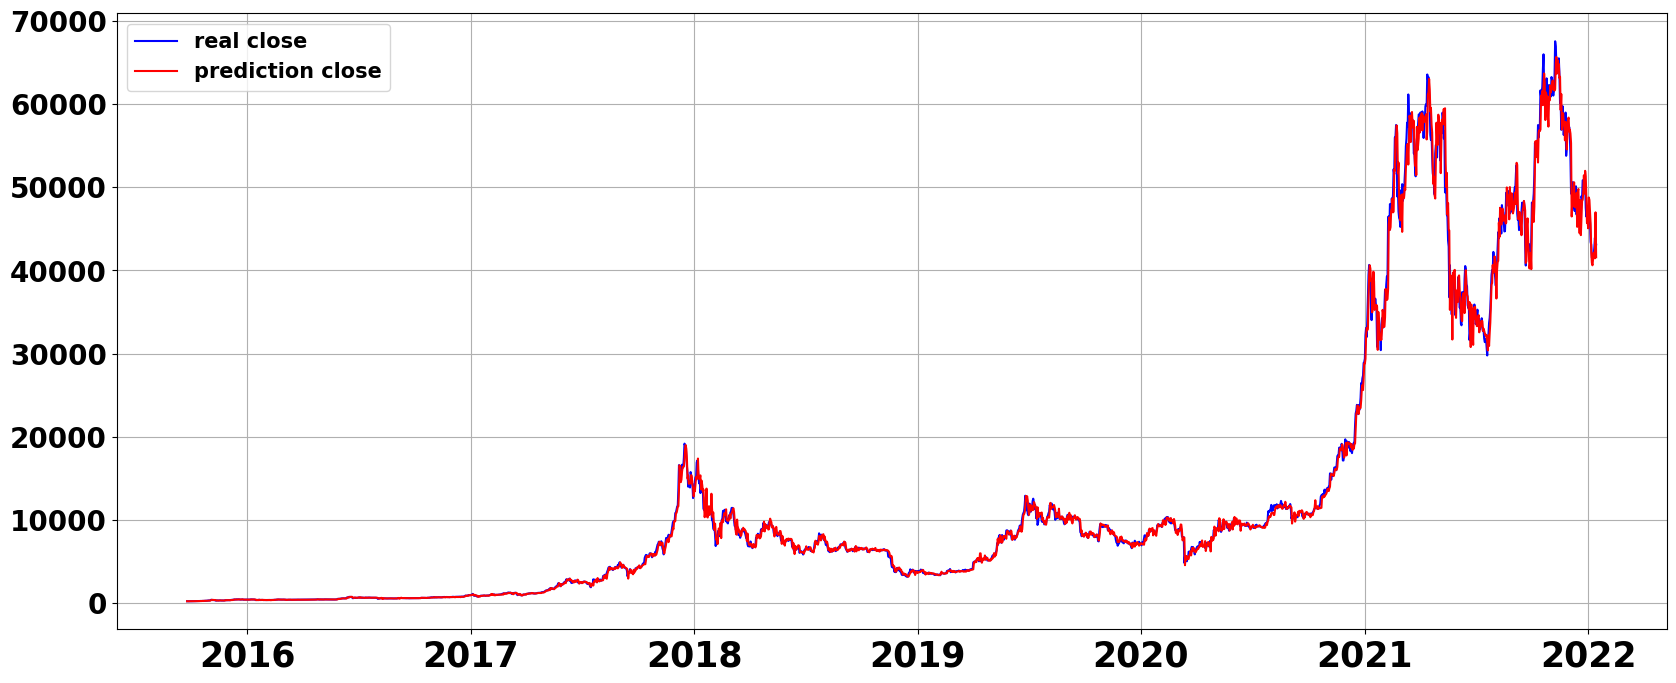

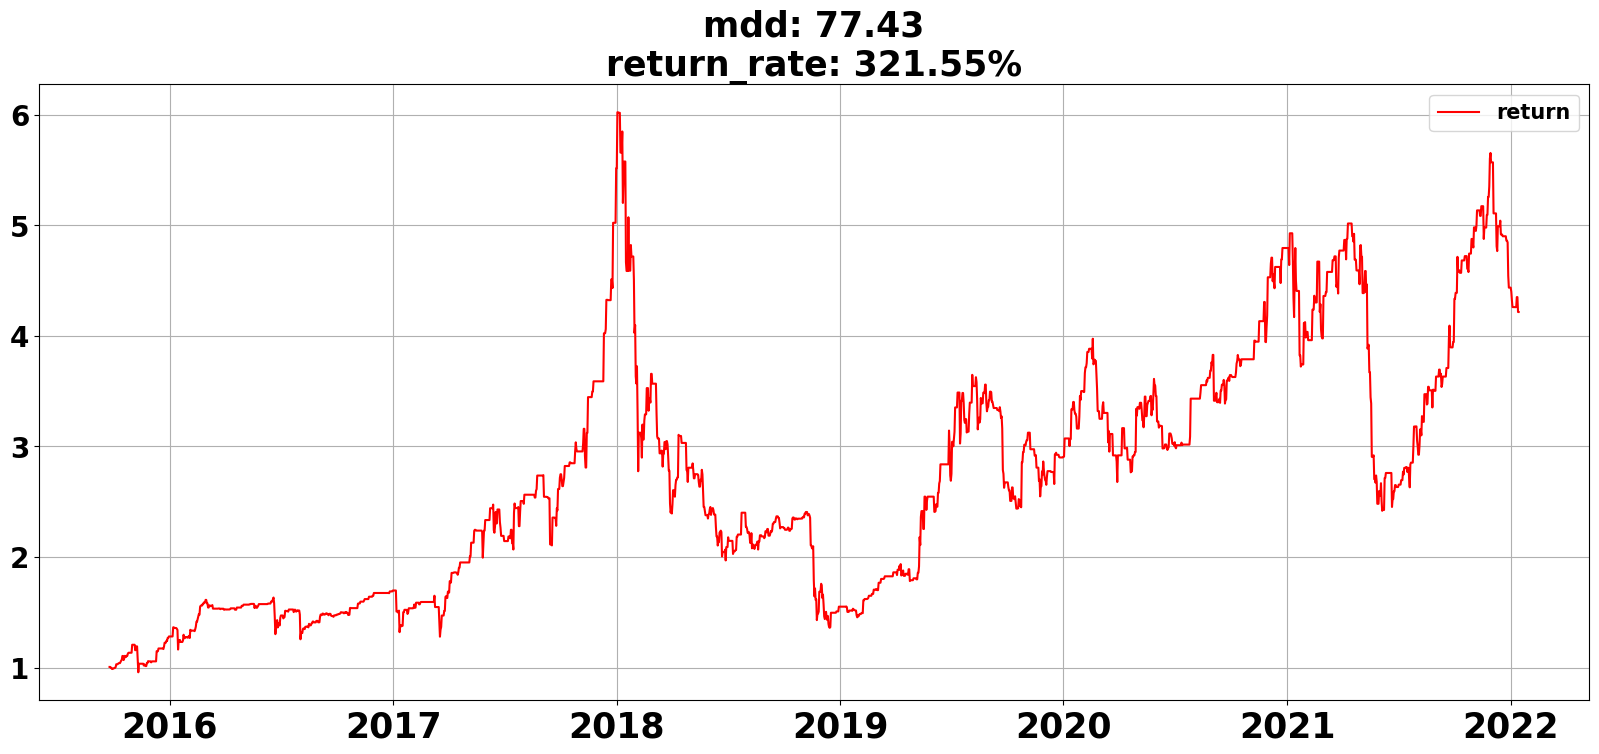

In [69]:
result_df = backtest_XGB_1d(final_price_df,300, 1)

In [70]:
analysis_return(result_df)

{'trade_rate': ' 45.79%',
 'success_rate': ' 54.22%',
 'pnl_rate': ' 1.17',
 'mdd': ' 77.43%',
 'cr': ' 321.55%'}

In [71]:
result_df

,o,c,v,dji_c,dji_v,exc_c,hash-rate,obv,obv_ema,signal_obv,...,p_lag_10,q_lag_10,pq_lag_10,target,prediction_close,batch_open,trade,ror,cr,mdd
2015-09-25 00:00:00,233.88,235.13,5.285211e+06,16314.67,130790000.0,1193.07,4.424364e+05,-2.772330e+07,-3.527845e+07,7.555150e+06,...,229.30,3.761714e+06,8.625610e+08,233.89,236.762405,233.88,1,1.005345,1.005345,0.000000
2015-09-26 00:00:00,235.14,233.89,3.523048e+06,16314.67,130790000.0,1193.07,4.483356e+05,-3.124635e+07,-3.508645e+07,3.840097e+06,...,227.85,3.425655e+06,7.805355e+08,231.91,234.291687,235.14,0,1.000000,1.005345,0.000000
2015-09-27 00:00:00,233.81,231.91,4.019534e+06,16314.67,130790000.0,1193.07,4.483356e+05,-3.526589e+07,-3.509499e+07,-1.708927e+05,...,232.44,3.367136e+06,7.826572e+08,239.00,235.909256,233.81,1,0.991874,0.997175,0.812626
2015-09-28 00:00:00,232.40,239.00,4.157772e+06,16001.89,139930000.0,1196.04,4.483356e+05,-3.110811e+07,-3.490514e+07,3.797028e+06,...,232.82,4.504784e+06,1.048804e+09,236.71,230.638245,232.40,0,1.000000,0.997175,0.812626
2015-09-29 00:00:00,239.14,236.71,4.647432e+06,16049.13,121160000.0,1196.02,5.102767e+05,-3.575555e+07,-3.494564e+07,-8.099095e+05,...,230.23,2.603720e+06,5.994544e+08,236.65,240.737366,239.14,1,0.989839,0.987042,1.820509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-10 00:00:00,41853.98,41845.42,3.494014e+03,36068.87,440300000.0,1198.04,1.720376e+08,-3.382907e+08,-3.382768e+08,-1.390293e+04,...,46214.37,1.798553e+03,8.311898e+07,42736.00,42146.078125,41853.98,1,0.999795,4.259451,29.270172
2022-01-11 00:00:00,41842.22,42736.00,2.442654e+03,36252.02,363190000.0,1192.31,1.914221e+08,-3.382883e+08,-3.382774e+08,-1.091454e+04,...,47777.42,7.415206e+02,3.542794e+07,43933.50,41954.867188,41842.22,1,1.021361,4.350436,27.759331
2022-01-12 00:00:00,42754.44,43933.50,2.502762e+03,36290.32,317860000.0,1185.87,1.684030e+08,-3.382858e+08,-3.382778e+08,-8.011221e+03,...,47350.22,7.020948e+02,3.324434e+07,42571.94,41469.175781,42754.44,0,1.000000,4.350436,27.759331
2022-01-13 00:00:00,43935.01,42571.94,1.993883e+03,36113.62,349740000.0,1186.11,2.168643e+08,-3.382878e+08,-3.382783e+08,-9.528671e+03,...,46439.89,1.140179e+03,5.294979e+07,43102.35,46993.347656,43935.01,1,0.968975,4.215465,30.000576


2054it [11:49,  2.89it/s]


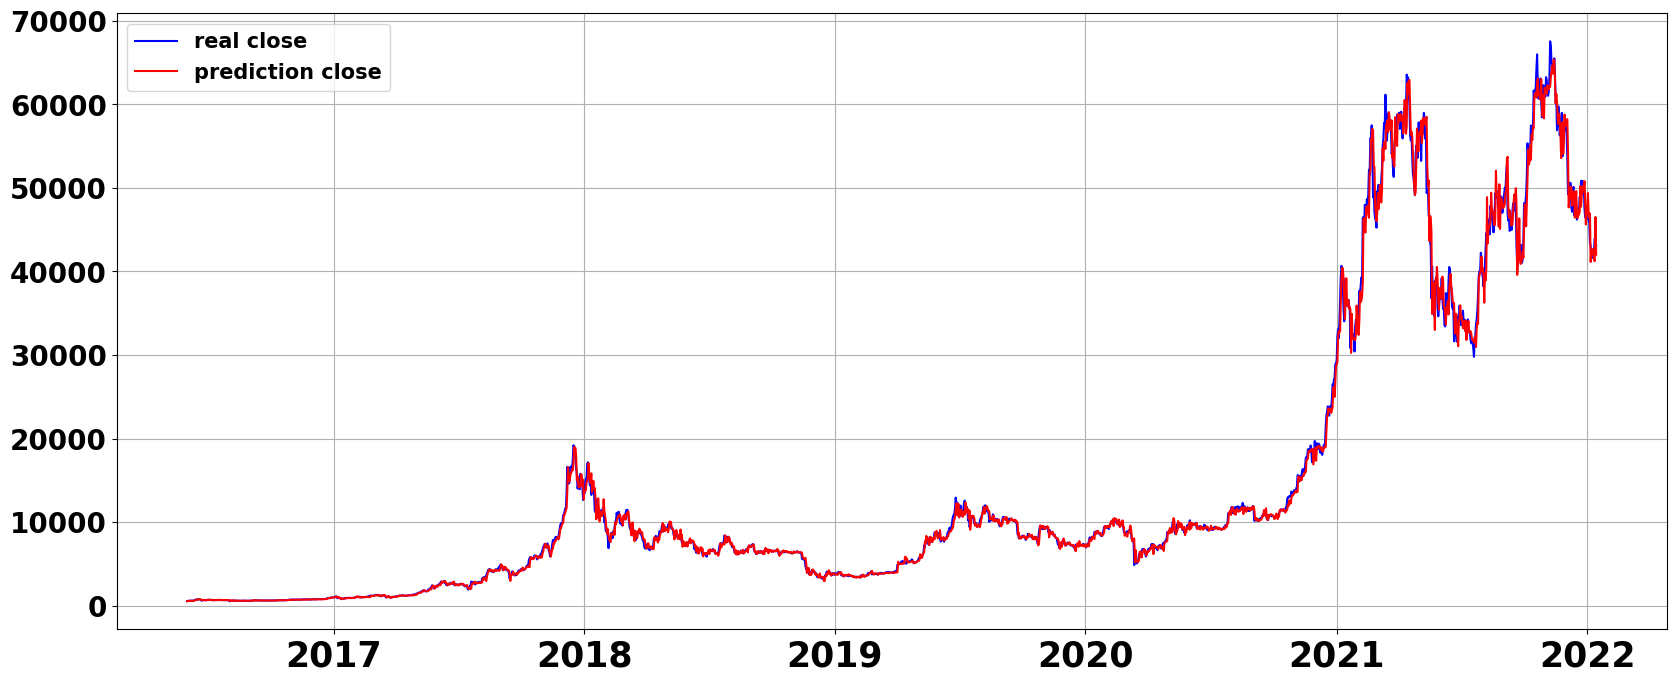

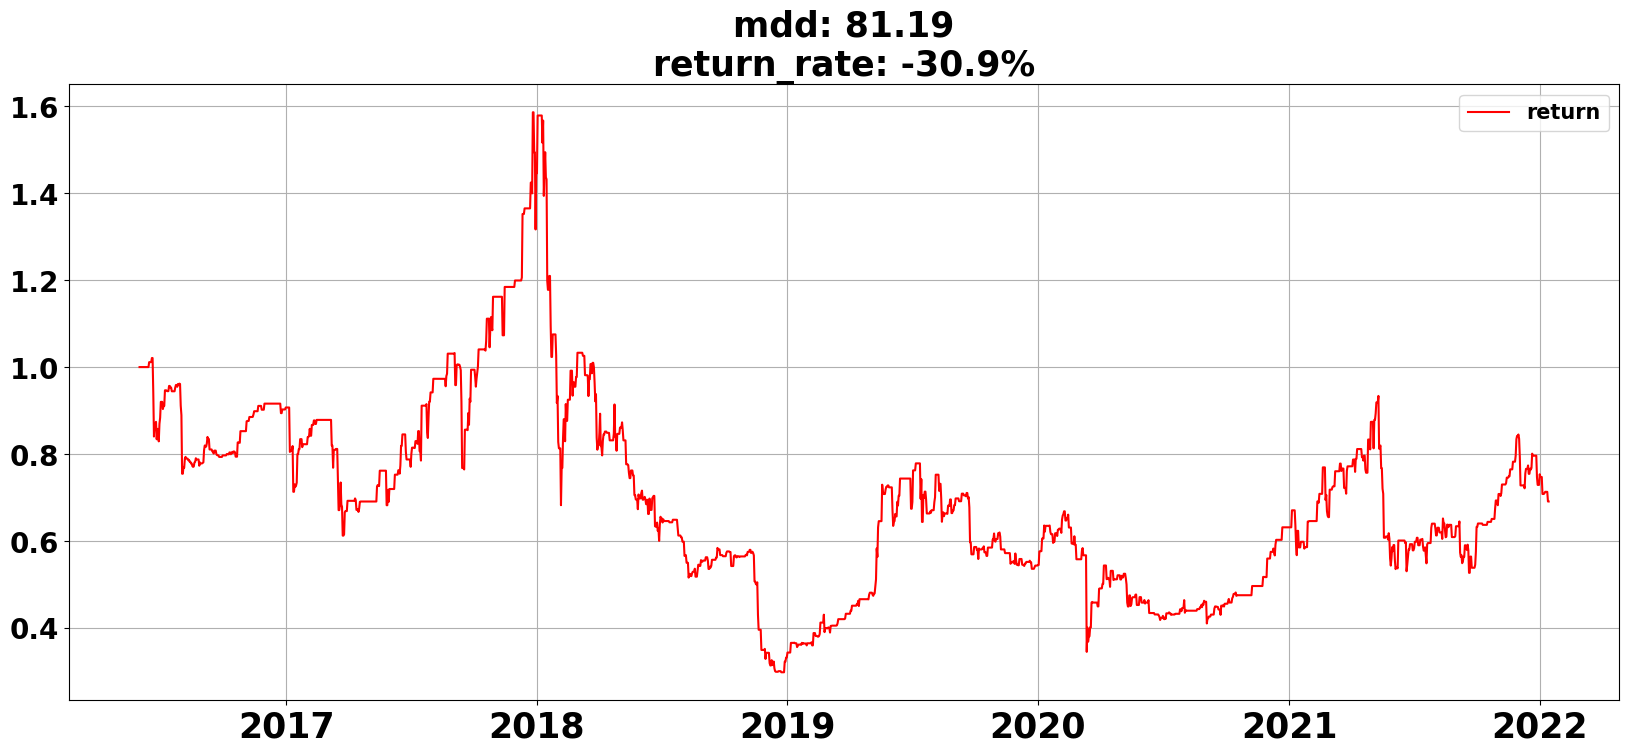

In [82]:
result_df1 = backtest_XGB_1d(final_price_df,550, 1)

In [83]:
analysis_return(result_df1)

{'trade_rate': ' 43.33%',
 'success_rate': ' 54.38%',
 'pnl_rate': ' 1.04',
 'mdd': ' 81.19%',
 'cr': '-30.90%'}

In [84]:
result_df1

,o,c,v,dji_c,dji_v,exc_c,hash-rate,obv,obv_ema,signal_obv,...,p_lag_10,q_lag_10,pq_lag_10,target,prediction_close,batch_open,trade,ror,cr,mdd
2016-06-01 00:00:00,532.37,538.65,2.882083e+06,17789.67,78530000.0,1192.37,1.426731e+06,1.931854e+08,1.703676e+08,2.281779e+07,...,437.85,1.007976e+06,4.413424e+08,538.98,516.623291,532.37,0,1.000000,1.000000,0.000000
2016-06-02 00:00:00,536.95,538.98,2.094444e+06,17838.56,75560000.0,1186.81,1.426731e+06,1.952799e+08,1.715539e+08,2.372593e+07,...,442.29,1.126275e+06,4.981400e+08,567.94,526.096924,536.95,0,1.000000,1.000000,0.000000
2016-06-03 00:00:00,538.00,567.94,4.871570e+06,17807.06,82280000.0,1163.55,1.426731e+06,2.001514e+08,1.729157e+08,2.723572e+07,...,445.31,1.358028e+06,6.047433e+08,573.87,528.535095,538.00,0,1.000000,1.000000,0.000000
2016-06-04 00:00:00,569.93,573.87,3.553069e+06,17807.06,82280000.0,1163.55,1.179035e+06,2.037045e+08,1.743819e+08,2.932265e+07,...,448.02,1.636080e+06,7.329965e+08,573.76,556.325317,569.93,0,1.000000,1.000000,0.000000
2016-06-05 00:00:00,573.50,573.76,3.061431e+06,17807.06,82280000.0,1163.55,1.179035e+06,2.006431e+08,1.756324e+08,2.501069e+07,...,452.38,1.693501e+06,7.661058e+08,583.49,569.180542,573.50,0,1.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-10 00:00:00,41853.98,41845.42,3.494014e+03,36068.87,440300000.0,1198.04,1.720376e+08,-3.382907e+08,-3.382768e+08,-1.390293e+04,...,46214.37,1.798553e+03,8.311898e+07,42736.00,42100.132812,41853.98,1,0.999795,0.713080,55.035473
2022-01-11 00:00:00,41842.22,42736.00,2.442654e+03,36252.02,363190000.0,1192.31,1.914221e+08,-3.382883e+08,-3.382774e+08,-1.091454e+04,...,47777.42,7.415206e+02,3.542794e+07,43933.50,41386.769531,41842.22,0,1.000000,0.713080,55.035473
2022-01-12 00:00:00,42754.44,43933.50,2.502762e+03,36290.32,317860000.0,1185.87,1.684030e+08,-3.382858e+08,-3.382778e+08,-8.011221e+03,...,47350.22,7.020948e+02,3.324434e+07,42571.94,41233.332031,42754.44,0,1.000000,0.713080,55.035473
2022-01-13 00:00:00,43935.01,42571.94,1.993883e+03,36113.62,349740000.0,1186.11,2.168643e+08,-3.382878e+08,-3.382783e+08,-9.528671e+03,...,46439.89,1.140179e+03,5.294979e+07,43102.35,46522.648438,43935.01,1,0.968975,0.690957,56.430484


2404it [07:42,  5.20it/s]


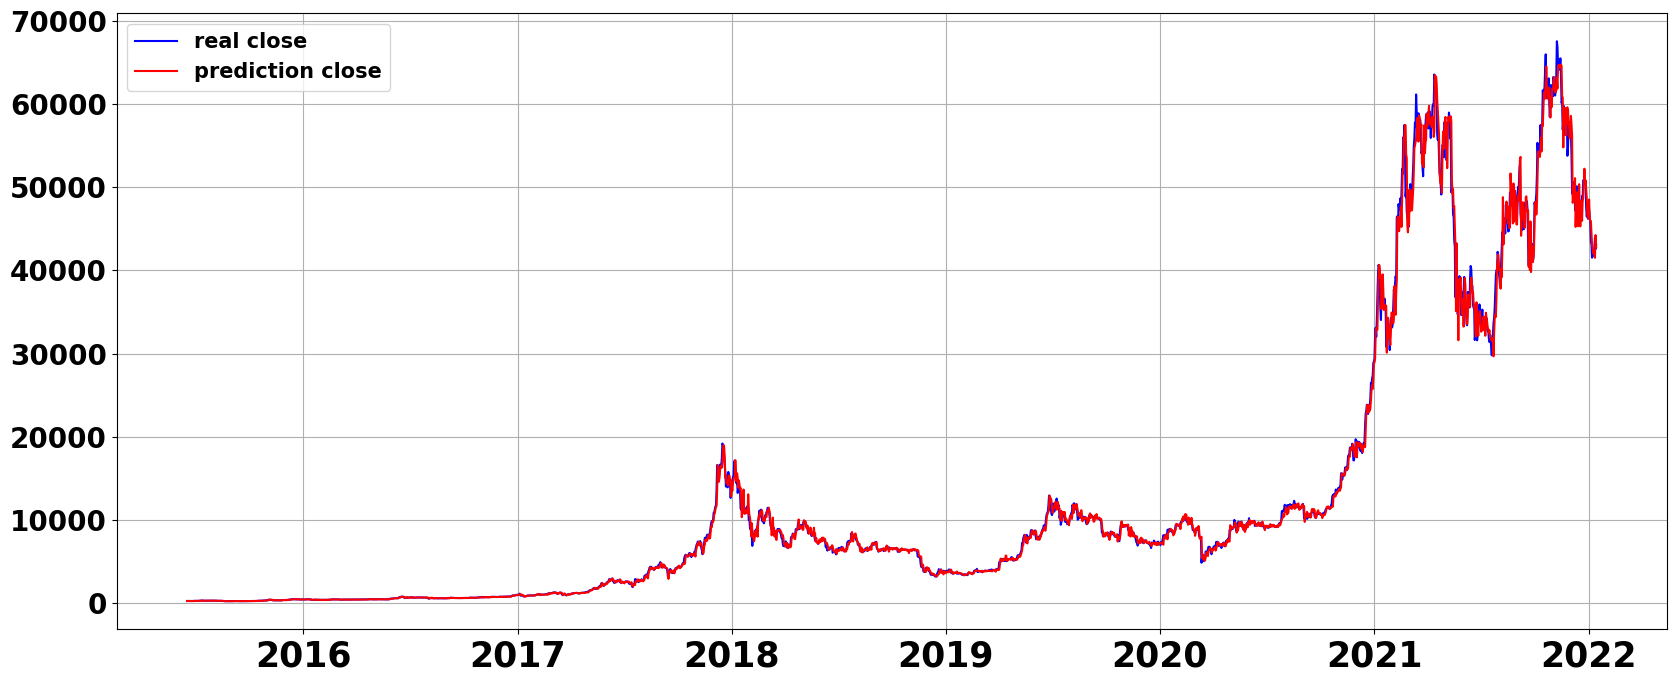

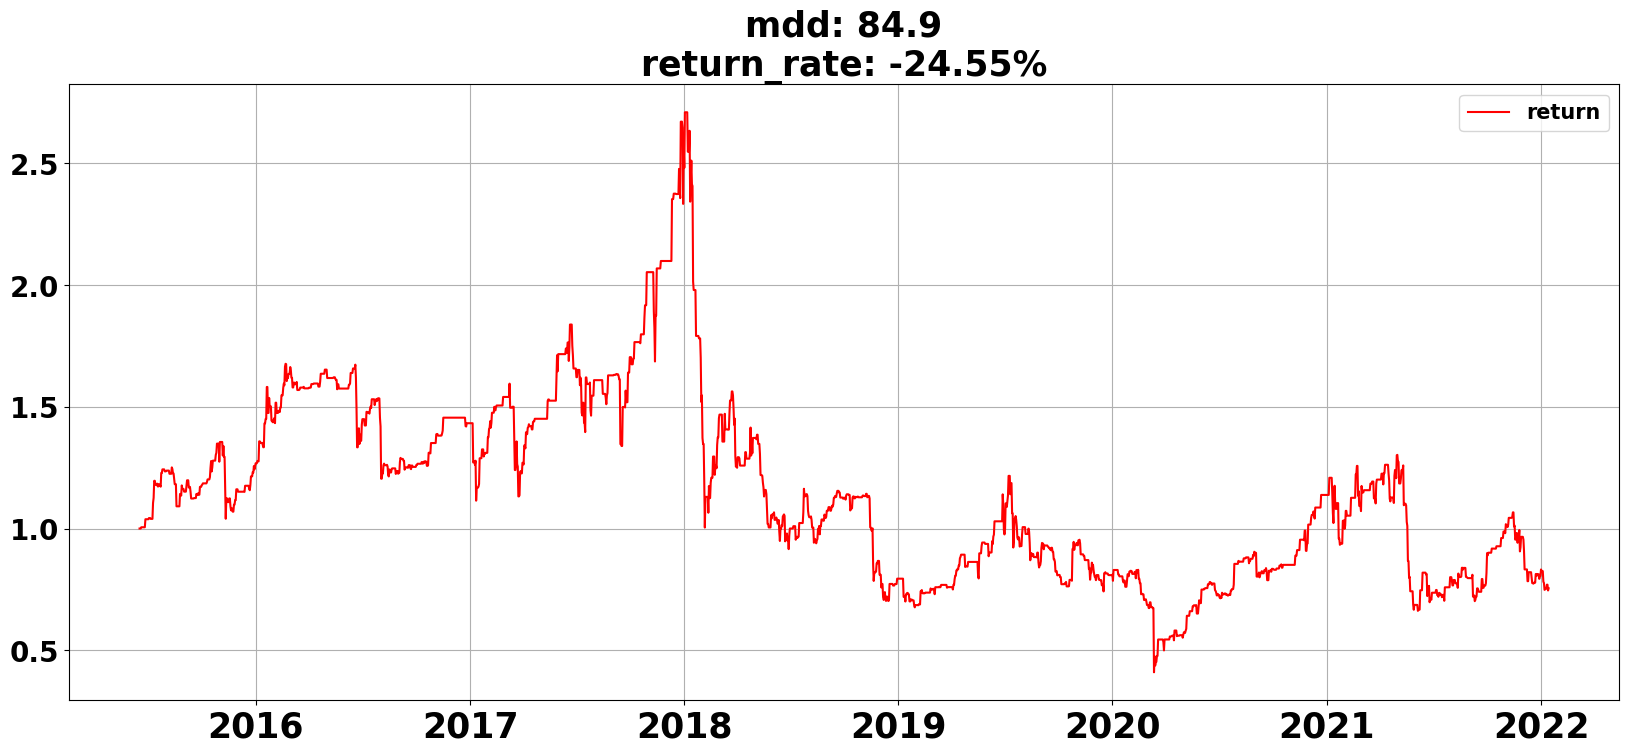

In [85]:
result_df2 = backtest_XGB_1d(final_price_df,200, 1)

In [86]:
analysis_return(result_df2)

{'trade_rate': ' 45.38%',
 'success_rate': ' 52.70%',
 'pnl_rate': ' 1.05',
 'mdd': ' 84.90%',
 'cr': '-24.55%'}

2354it [08:20,  4.71it/s]


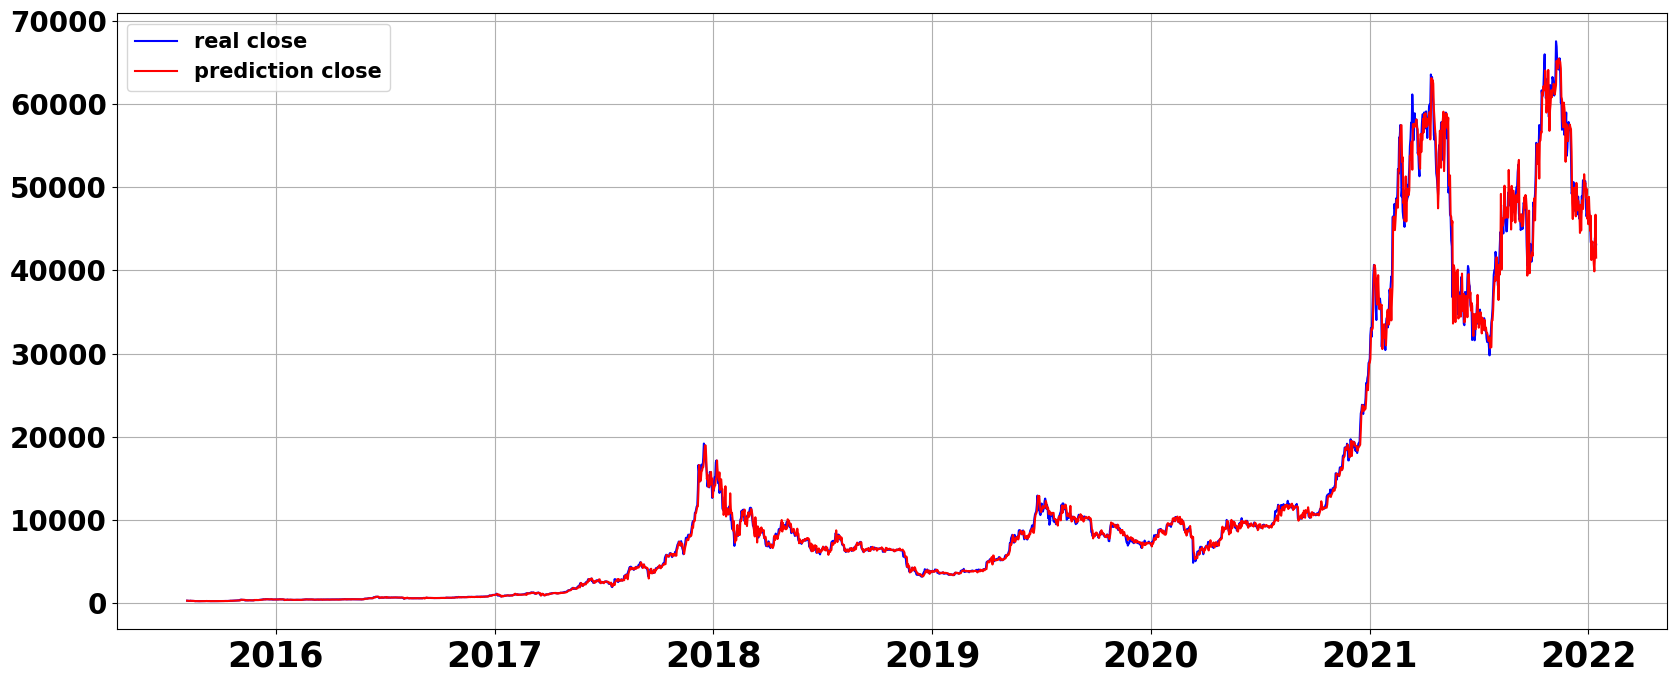

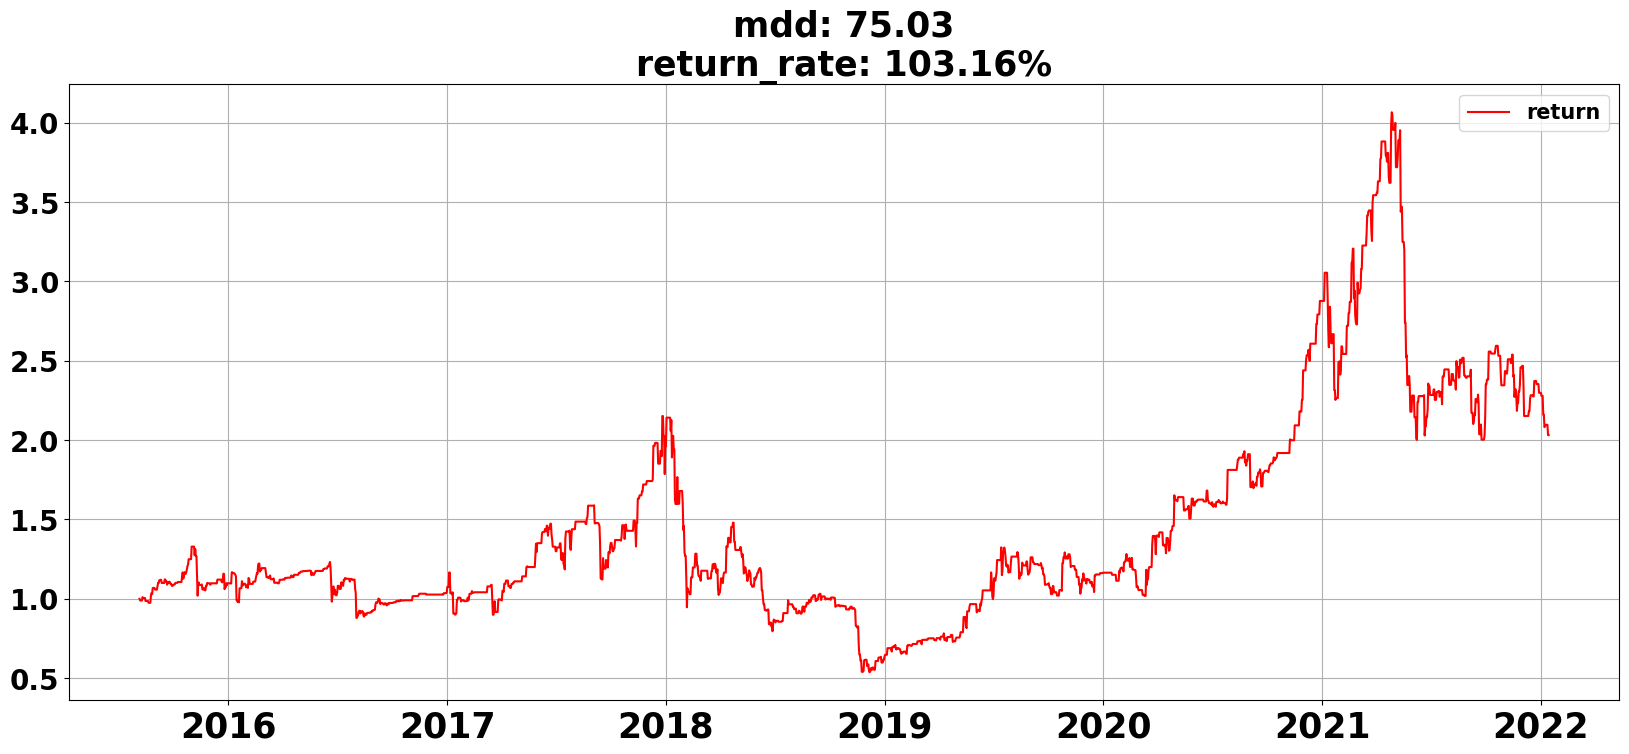

In [87]:
result_df3 = backtest_XGB_1d(final_price_df,250, 1)

In [88]:
analysis_return(result_df3)

{'trade_rate': ' 45.45%',
 'success_rate': ' 54.02%',
 'pnl_rate': ' 1.12',
 'mdd': ' 75.03%',
 'cr': ' 103.16%'}

In [89]:
result_df3

,o,c,v,dji_c,dji_v,exc_c,hash-rate,obv,obv_ema,signal_obv,...,p_lag_10,q_lag_10,pq_lag_10,target,prediction_close,batch_open,trade,ror,cr,mdd
2015-08-06 00:00:00,281.99,281.99,0.000000e+00,17419.75,96170000.0,1163.68,3.638276e+05,-2.421985e+07,-2.386801e+07,-3.518399e+05,...,294.27,4.226344e+06,1.243686e+09,279.01,278.049500,281.99,0,1.000000,1.000000,0.000000
2015-08-07 00:00:00,281.99,279.01,1.158954e+06,17373.38,81800000.0,1164.70,3.638276e+05,-2.537880e+07,-2.393995e+07,-1.438851e+06,...,293.84,2.643989e+06,7.769098e+08,261.71,284.220795,281.99,1,0.989432,0.989432,1.056775
2015-08-08 00:00:00,279.01,261.71,2.760954e+06,17373.38,81800000.0,1164.70,3.638276e+05,-2.813975e+07,-2.413994e+07,-3.999814e+06,...,289.63,2.965536e+06,8.589081e+08,265.36,278.707245,279.01,0,1.000000,0.989432,1.056775
2015-08-09 00:00:00,261.71,265.36,2.374804e+06,17373.38,81800000.0,1164.70,3.536627e+05,-2.576495e+07,-2.421732e+07,-1.547628e+06,...,287.73,2.298108e+06,6.612345e+08,264.33,254.469452,261.71,0,1.000000,0.989432,1.056775
2015-08-10 00:00:00,265.36,264.33,2.579884e+06,17615.17,92430000.0,1159.20,3.536627e+05,-2.834483e+07,-2.441387e+07,-3.930963e+06,...,284.39,2.218539e+06,6.309304e+08,270.00,254.041763,265.36,0,1.000000,0.989432,1.056775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-10 00:00:00,41853.98,41845.42,3.494014e+03,36068.87,440300000.0,1198.04,1.720376e+08,-3.382907e+08,-3.382768e+08,-1.390293e+04,...,46214.37,1.798553e+03,8.311898e+07,42736.00,40840.871094,41853.98,0,1.000000,2.096603,48.432011
2022-01-11 00:00:00,41842.22,42736.00,2.442654e+03,36252.02,363190000.0,1192.31,1.914221e+08,-3.382883e+08,-3.382774e+08,-1.091454e+04,...,47777.42,7.415206e+02,3.542794e+07,43933.50,39890.207031,41842.22,0,1.000000,2.096603,48.432011
2022-01-12 00:00:00,42754.44,43933.50,2.502762e+03,36290.32,317860000.0,1185.87,1.684030e+08,-3.382858e+08,-3.382778e+08,-8.011221e+03,...,47350.22,7.020948e+02,3.324434e+07,42571.94,41818.191406,42754.44,0,1.000000,2.096603,48.432011
2022-01-13 00:00:00,43935.01,42571.94,1.993883e+03,36113.62,349740000.0,1186.11,2.168643e+08,-3.382878e+08,-3.382783e+08,-9.528671e+03,...,46439.89,1.140179e+03,5.294979e+07,43102.35,46699.273438,43935.01,1,0.968975,2.031556,50.031892


## 100일 학습 후 1일 예측 공동평가 지표 

2504it [05:57,  7.00it/s]


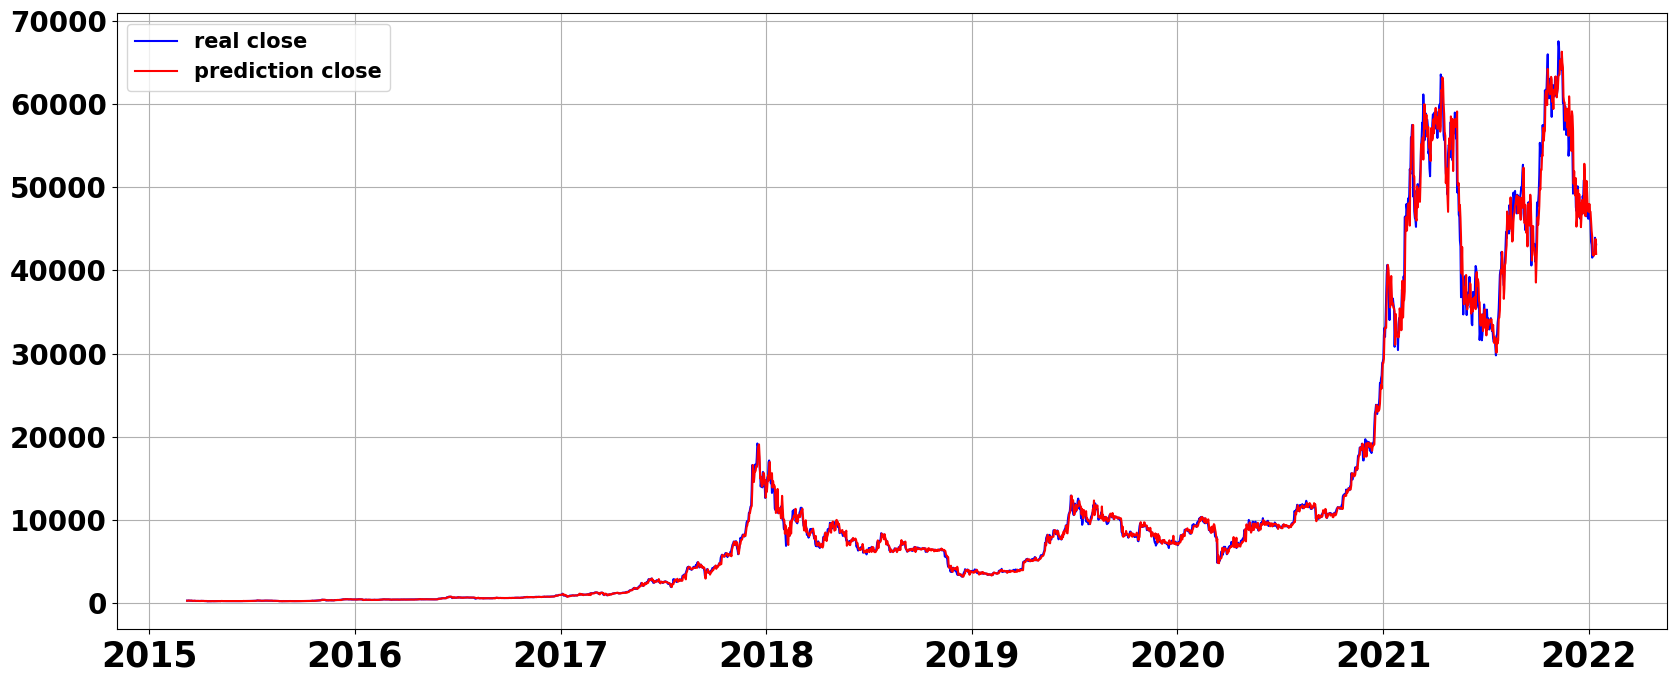

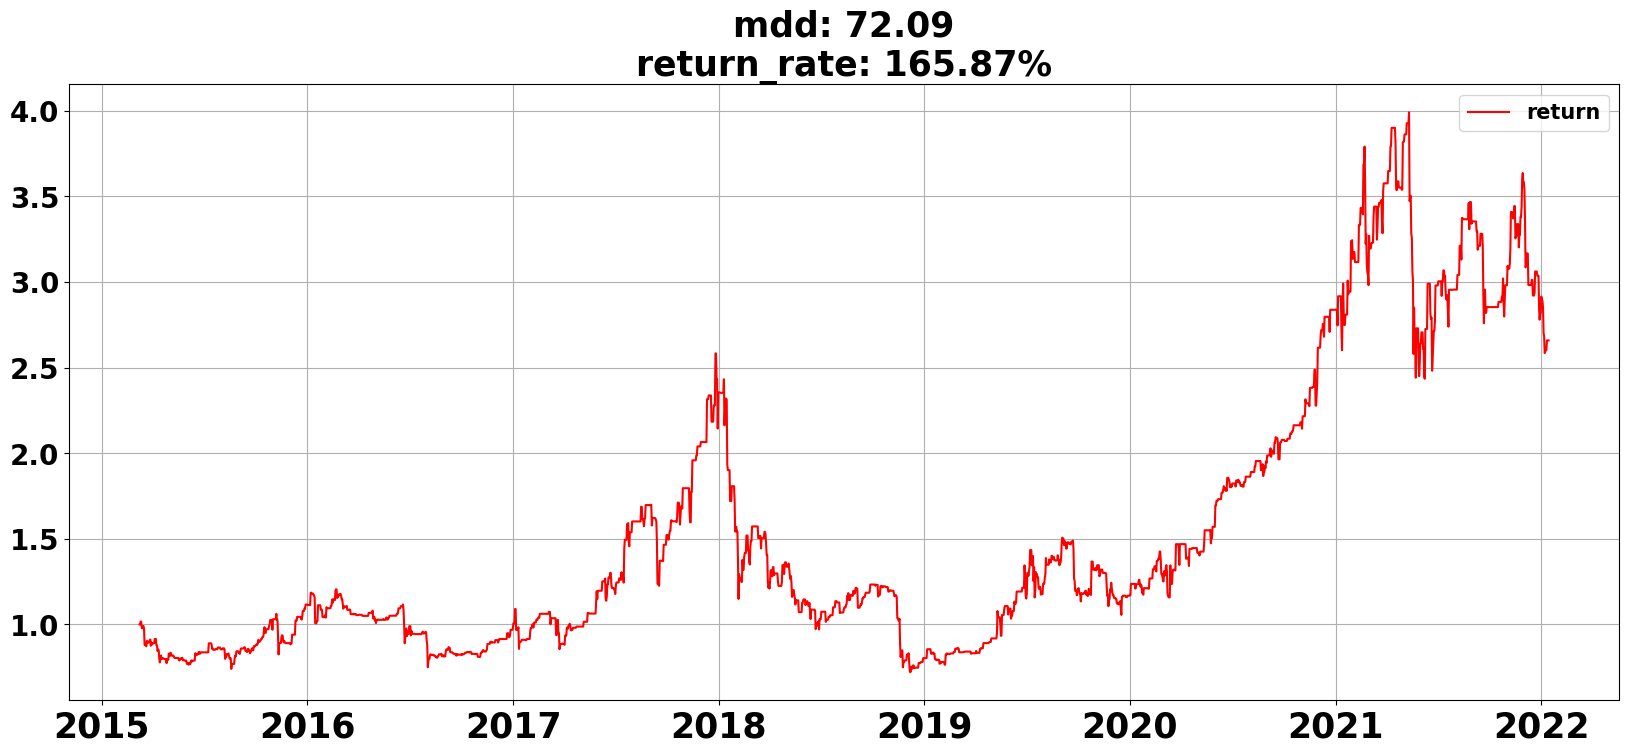

In [72]:
result_df4 = backtest_XGB_1d(final_price_df,100, 1)

In [73]:
analysis_return(result_df4)

{'trade_rate': ' 45.73%',
 'success_rate': ' 54.15%',
 'pnl_rate': ' 1.13',
 'mdd': ' 72.09%',
 'cr': ' 165.87%'}

In [74]:
result_df4

,o,c,v,dji_c,dji_v,exc_c,hash-rate,obv,obv_ema,signal_obv,...,p_lag_10,q_lag_10,pq_lag_10,target,prediction_close,batch_open,trade,ror,cr,mdd
2015-03-09 00:00:00,274.89,287.00,3.389556e+06,17995.72,85820000.0,1115.00,3.112080e+05,-3.458859e+07,-4.285863e+07,8.270039e+06,...,253.06,5.507720e+06,1.393784e+09,290.24,274.136078,274.89,0,1.000000,1.000000,0.000000
2015-03-10 00:00:00,287.00,290.24,3.744249e+06,17662.94,120450000.0,1127.41,3.112080e+05,-3.084434e+07,-4.228255e+07,1.143821e+07,...,252.98,9.068749e+05,2.294212e+08,295.11,269.749390,287.00,0,1.000000,1.000000,0.000000
2015-03-11 00:00:00,290.24,295.11,1.979535e+06,17635.39,102120000.0,1132.08,3.112080e+05,-2.886481e+07,-4.163938e+07,1.277458e+07,...,255.81,1.275703e+06,3.263376e+08,295.56,292.676849,290.24,1,1.016779,1.016779,0.000000
2015-03-12 00:00:00,295.11,295.56,2.399612e+06,17895.22,111550000.0,1125.64,3.135657e+05,-2.646519e+07,-4.091225e+07,1.444706e+07,...,274.00,2.598171e+06,7.118988e+08,284.40,293.836395,295.11,0,1.000000,1.016779,0.000000
2015-03-13 00:00:00,295.56,284.40,2.654225e+06,17749.31,113630000.0,1138.12,3.135657e+05,-2.911942e+07,-4.034732e+07,1.122790e+07,...,279.00,6.104062e+06,1.703033e+09,282.70,295.748322,295.56,1,0.962241,0.978387,3.775883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-10 00:00:00,41853.98,41845.42,3.494014e+03,36068.87,440300000.0,1198.04,1.720376e+08,-3.382907e+08,-3.382768e+08,-1.390293e+04,...,46214.37,1.798553e+03,8.311898e+07,42736.00,41769.746094,41853.98,0,1.000000,2.603049,34.778244
2022-01-11 00:00:00,41842.22,42736.00,2.442654e+03,36252.02,363190000.0,1192.31,1.914221e+08,-3.382883e+08,-3.382774e+08,-1.091454e+04,...,47777.42,7.415206e+02,3.542794e+07,43933.50,42069.566406,41842.22,1,1.021361,2.658652,33.385060
2022-01-12 00:00:00,42754.44,43933.50,2.502762e+03,36290.32,317860000.0,1185.87,1.684030e+08,-3.382858e+08,-3.382778e+08,-8.011221e+03,...,47350.22,7.020948e+02,3.324434e+07,42571.94,42182.808594,42754.44,0,1.000000,2.658652,33.385060
2022-01-13 00:00:00,43935.01,42571.94,1.993883e+03,36113.62,349740000.0,1186.11,2.168643e+08,-3.382878e+08,-3.382783e+08,-9.528671e+03,...,46439.89,1.140179e+03,5.294979e+07,43102.35,43774.992188,43935.01,0,1.000000,2.658652,33.385060


## 공동평가가지표 RMSE

In [75]:
from sklearn.metrics import mean_squared_error
y=result_df['c']
y_pred=result_df['prediction_close']
RMSE = mean_squared_error(y, y_pred)**0.5
print(RMSE)

1034.7388558438827


2554it [04:34,  9.32it/s]


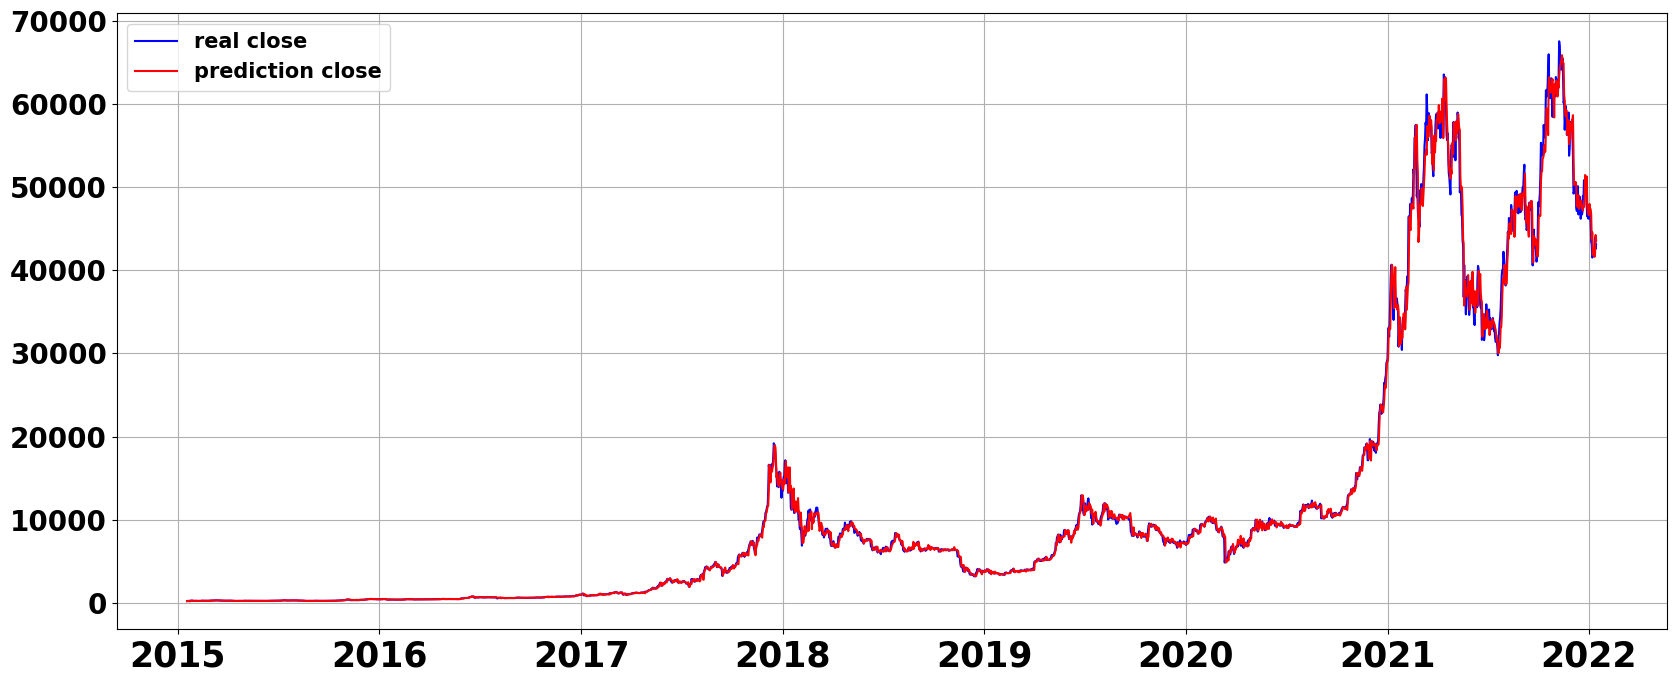

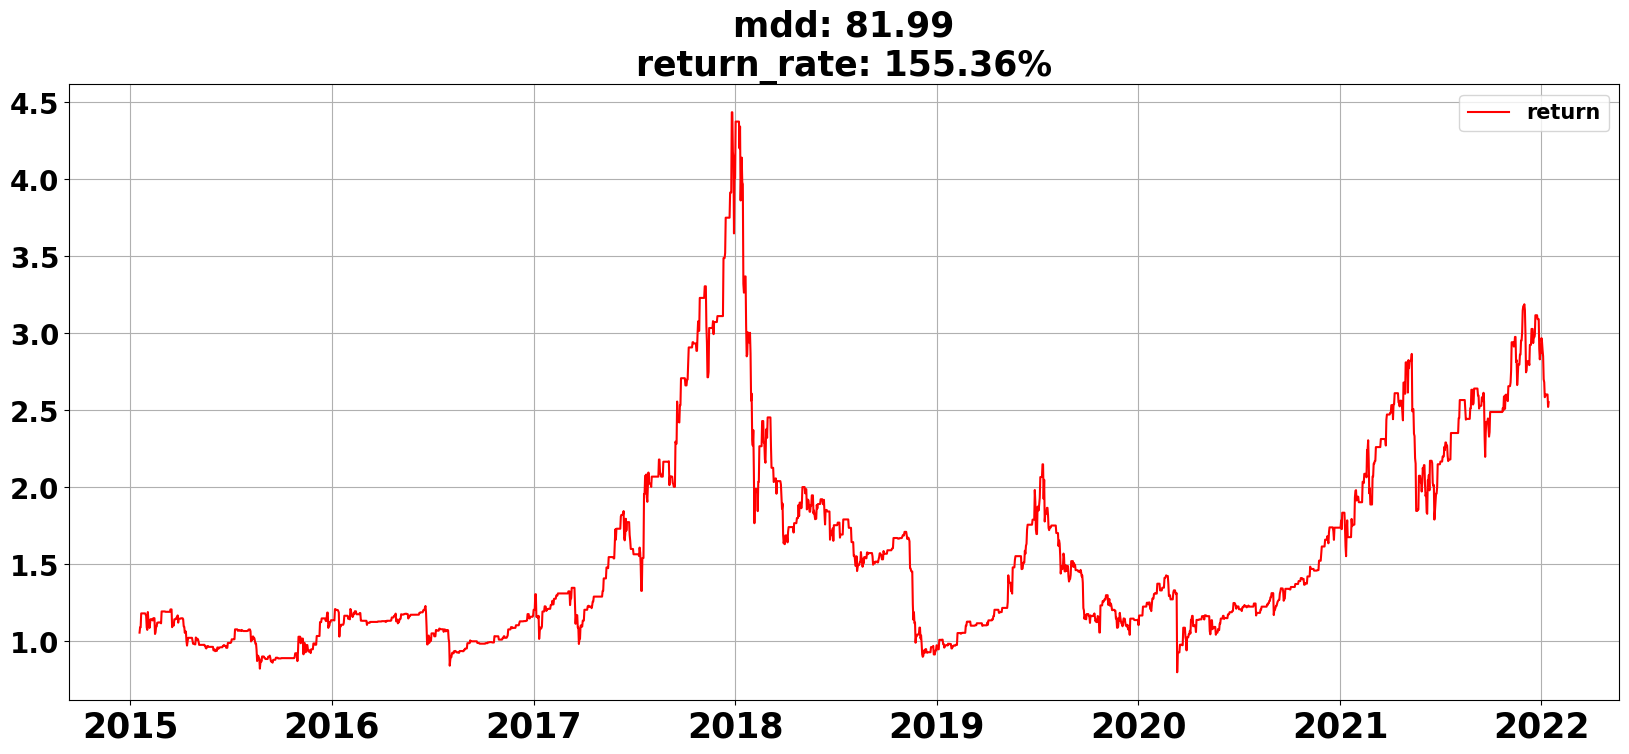

In [76]:
result_df5 = backtest_XGB_1d(final_price_df,50, 1)

In [77]:
analysis_return(result_df5)

{'trade_rate': ' 45.11%',
 'success_rate': ' 54.69%',
 'pnl_rate': ' 1.13',
 'mdd': ' 81.99%',
 'cr': ' 155.36%'}

2254it [10:18,  3.65it/s]


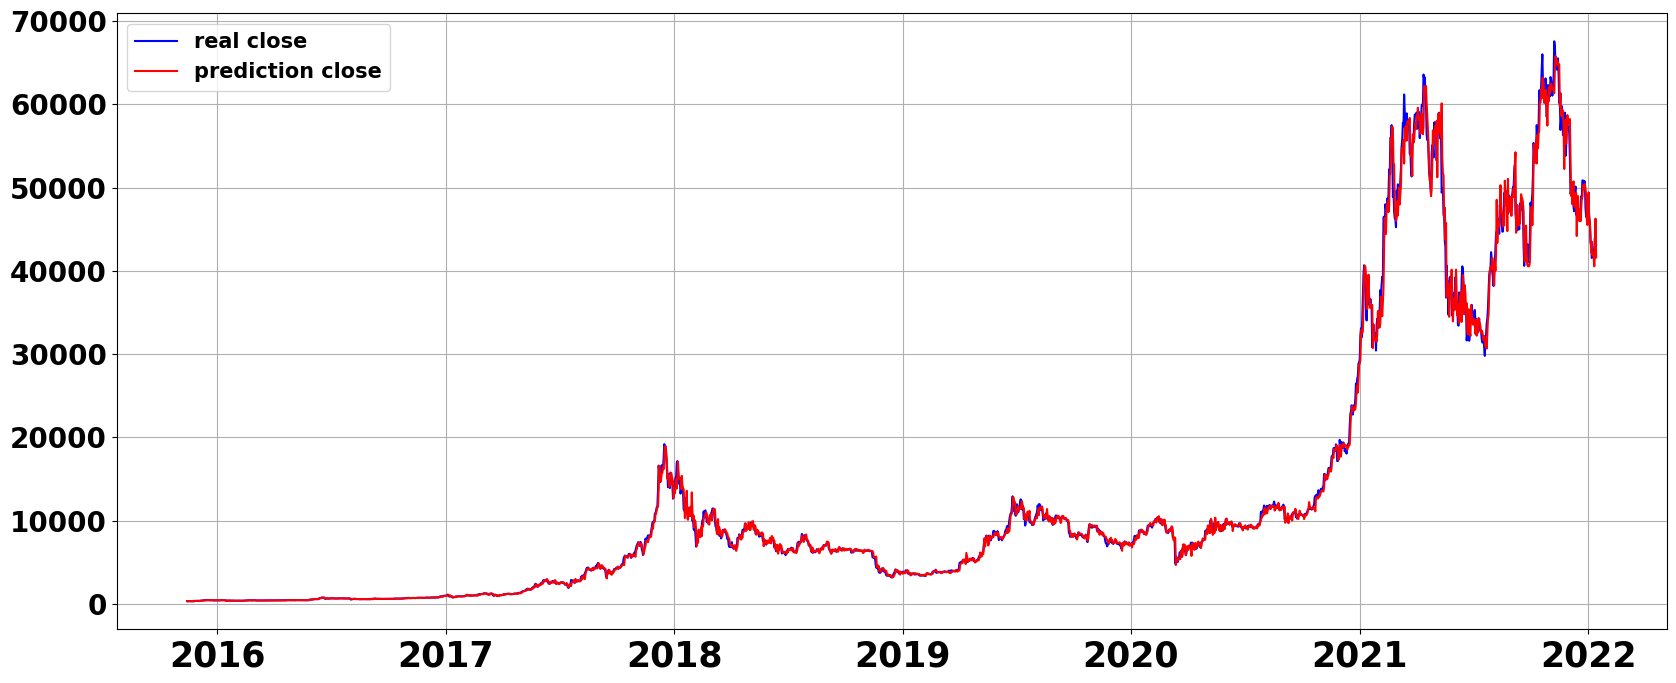

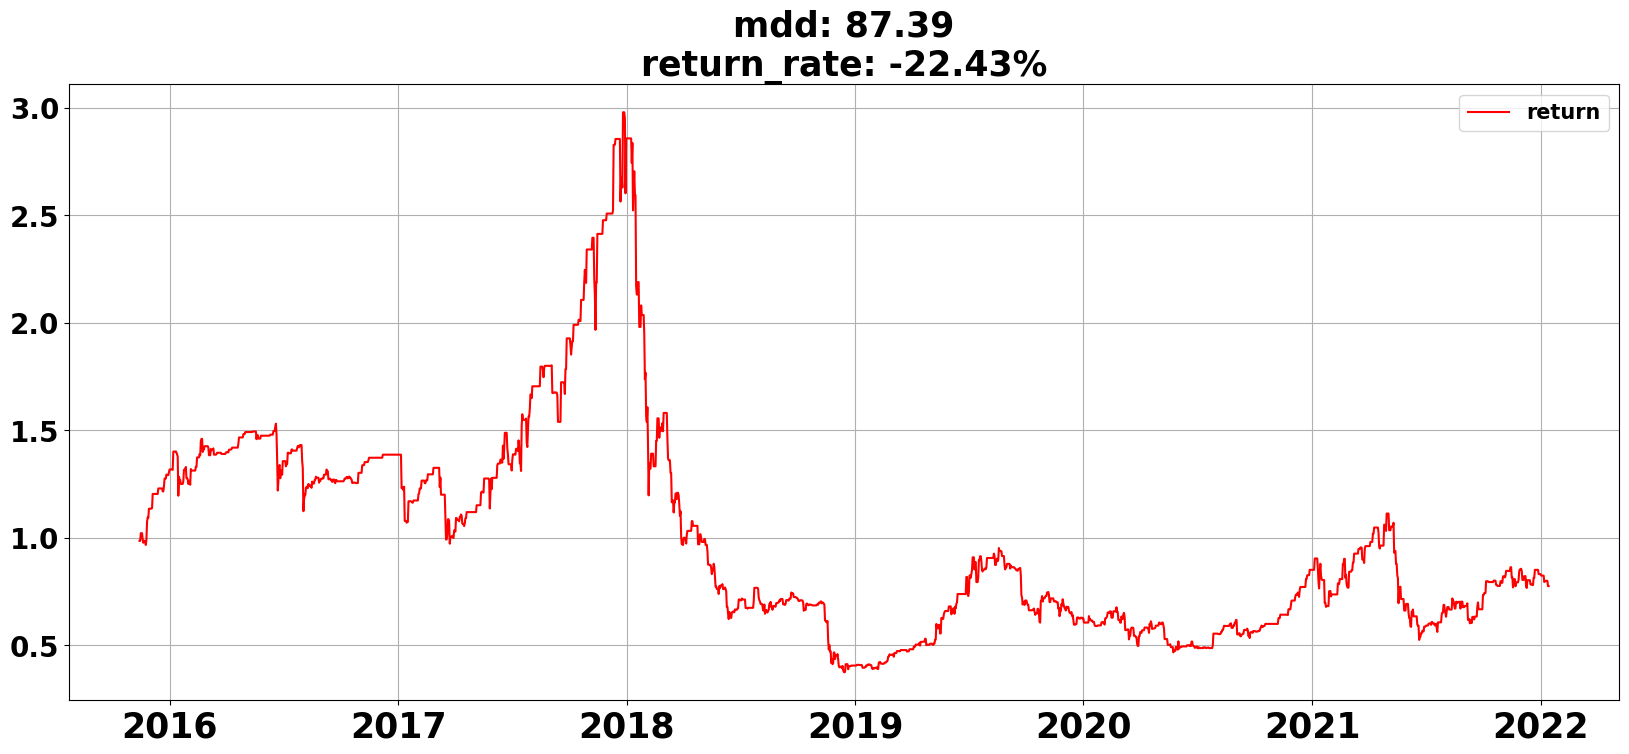

In [78]:
result_df6 = backtest_XGB_1d(final_price_df,350, 1)

In [79]:
analysis_return(result_df6)

{'trade_rate': ' 47.03%',
 'success_rate': ' 51.70%',
 'pnl_rate': ' 1.04',
 'mdd': ' 87.39%',
 'cr': '-22.43%'}

2204it [10:23,  3.54it/s]


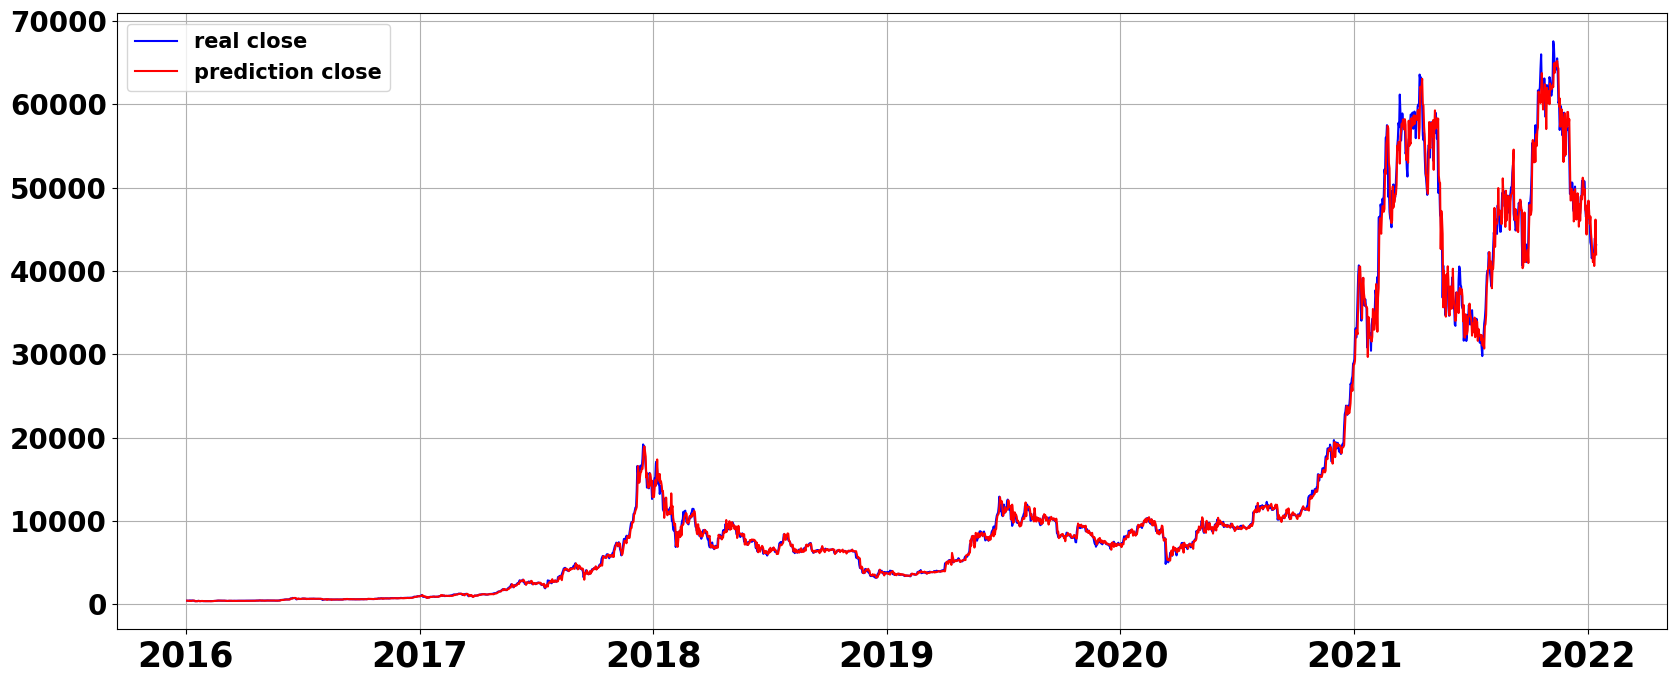

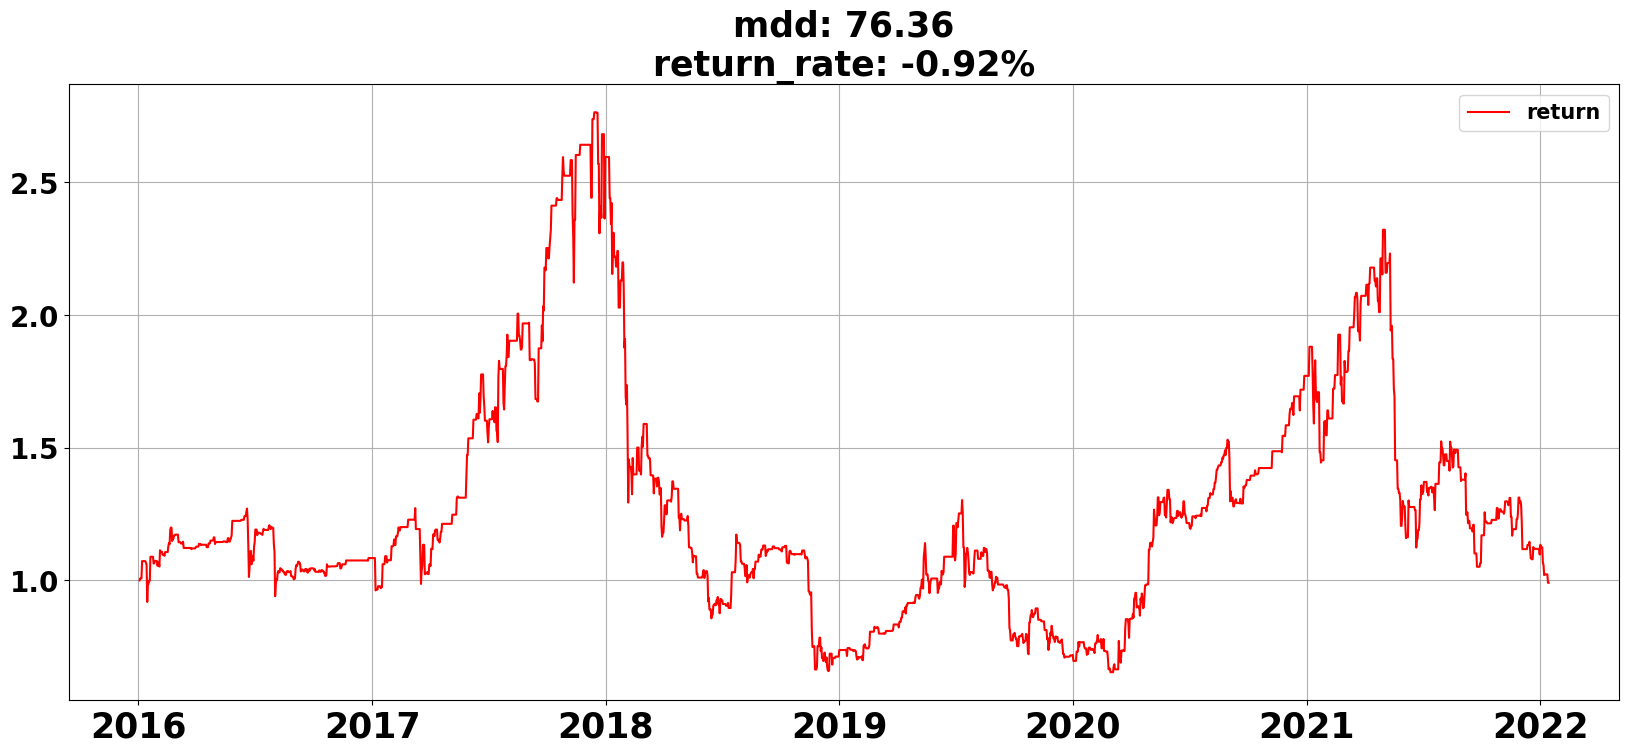

In [80]:
result_df7 = backtest_XGB_1d(final_price_df,400, 1)

In [81]:
result_df7 

,o,c,v,dji_c,dji_v,exc_c,hash-rate,obv,obv_ema,signal_obv,...,p_lag_10,q_lag_10,pq_lag_10,target,prediction_close,batch_open,trade,ror,cr,mdd
2016-01-03 00:00:00,433.20,430.85,1.930487e+06,17425.03,93690000.0,1175.45,7.694240e+05,1.357247e+08,1.312312e+08,4.493525e+06,...,455.71,4.589003e+06,2.091254e+09,433.97,431.899170,433.20,0,1.000000,1.000000,0.00000
2016-01-04 00:00:00,430.79,433.97,2.467177e+06,17148.94,148060000.0,1190.35,7.694240e+05,1.381919e+08,1.315627e+08,6.629240e+06,...,455.50,1.299892e+06,5.921009e+08,431.89,431.752686,430.79,1,1.007382,1.007382,0.00000
2016-01-05 00:00:00,434.17,431.89,1.668756e+06,17158.66,105750000.0,1190.81,7.694240e+05,1.365231e+08,1.317989e+08,4.724270e+06,...,417.42,1.127603e+07,4.706840e+09,431.84,429.020264,434.17,0,1.000000,1.007382,0.00000
2016-01-06 00:00:00,432.45,431.84,2.291149e+06,16906.51,120250000.0,1200.52,7.022931e+05,1.342320e+08,1.319147e+08,2.317258e+06,...,423.29,2.864576e+06,1.212546e+09,457.79,402.607239,432.45,0,1.000000,1.007382,0.00000
2016-01-07 00:00:00,429.99,457.79,7.127391e+06,16514.10,176240000.0,1197.29,7.022931e+05,1.413594e+08,1.323645e+08,8.994904e+06,...,420.70,3.151306e+06,1.325754e+09,451.32,432.075500,429.99,1,1.064653,1.072512,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-10 00:00:00,41853.98,41845.42,3.494014e+03,36068.87,440300000.0,1198.04,1.720376e+08,-3.382907e+08,-3.382768e+08,-1.390293e+04,...,46214.37,1.798553e+03,8.311898e+07,42736.00,42001.851562,41853.98,1,0.999795,1.022527,63.01075
2022-01-11 00:00:00,41842.22,42736.00,2.442654e+03,36252.02,363190000.0,1192.31,1.914221e+08,-3.382883e+08,-3.382774e+08,-1.091454e+04,...,47777.42,7.415206e+02,3.542794e+07,43933.50,40595.429688,41842.22,0,1.000000,1.022527,63.01075
2022-01-12 00:00:00,42754.44,43933.50,2.502762e+03,36290.32,317860000.0,1185.87,1.684030e+08,-3.382858e+08,-3.382778e+08,-8.011221e+03,...,47350.22,7.020948e+02,3.324434e+07,42571.94,41943.242188,42754.44,0,1.000000,1.022527,63.01075
2022-01-13 00:00:00,43935.01,42571.94,1.993883e+03,36113.62,349740000.0,1186.11,2.168643e+08,-3.382878e+08,-3.382783e+08,-9.528671e+03,...,46439.89,1.140179e+03,5.294979e+07,43102.35,46163.539062,43935.01,1,0.968975,0.990804,64.15833
